# Feature Engineering

## Objectives

This notebook implements **feature engineering** actions recommended by the exploratory analysis in Notebook 04. The goal is to transform raw and enriched datasets into modeling-ready features that address rating inflation, correct skewed distributions, and aggregate user-level signals for clustering and personalization.

Key priorities:

* Bayesian/weighted ratings to correct sample-size bias
* Log transformations for skewed count features
* User profile aggregation for segmentation and clustering
* Save feature-engineered datasets for modeling

---

## Inputs

* `internal_catalog_analysis.csv` — feature-engineered internal catalog
* `supply_catalog_analysis.csv` — feature-engineered supply catalog
* `ratings_clean_v1.csv` — cleaned user–book interactions
* `user_activity.csv`, `user_diversity.csv`, `user_genre_prefs.csv` — user-level analysis datasets
* `model_dataset_warm_start.csv` — unified metadata + external signals (for validation)

---

## Tasks in This Notebook

1. **Load Data**
    Import feature-engineered catalogs and user interaction datasets.

2. **Implement Bayesian/Weighted Ratings**
   Apply Bayesian average formula to correct rating inflation in low-volume books, authors, genres, and publishers.

3. **Apply Log Transformations**
   Transform skewed count features (ratings, author/publisher book counts) for regression compatibility.

4. **Aggregate User Profile Features**
   Merge rating, diversity, and preference metrics into user-level features for clustering and segmentation.

5. **Save Feature-Engineered Datasets**
   Export modeling-ready datasets for downstream tasks.

---

## Outputs

* Feature-engineered catalogs with weighted ratings and log-transformed features
* Aggregated user profile dataset for clustering and personalization
* Modeling-ready datasets saved to `outputs/datasets/modeling/`
* Documentation of feature engineering logic and business rationale

>**Note:**
>This notebook focuses on **feature engineering only**.
>Model training and evaluation are completed in the following notebooks.

# Set up

## Navigate to the Parent Directory

Before combining and saving datasets, it’s often helpful to move to a parent directory so that file operations (like loading or saving data) are easier and more organized. 

Before using the Python’s built-in os module to move one level up from the current working directory, it is advisable to inspect the current directory.

In [ ]:
import os

# Get the current working directory
current_dir = os.getcwd()
print(f'Current directory: {current_dir}')

To change to parent directory (root folder), run the code below. If you are already in the root folder, you can skip this step.

In [ ]:
# Change the working directory to its parent
os.chdir(os.path.dirname(current_dir))
print('Changed directory to parent.')

# Get the new current working directory (the parent directory)
current_dir = os.getcwd()
print(f'New current directory: {current_dir}')

## Load Datasets

In this step, we load the previously cleaned datasets for analysis.

In [ ]:
import pandas as pd

# catalogs
internal_catalog_fe = pd.read_csv('outputs/datasets/analysis/internal_catalog_analysis.csv')

# ratings and user-level analysis
ratings = pd.read_csv('outputs/datasets/cleaned/ratings_clean.csv')
user_activity = pd.read_csv('outputs/datasets/analysis/user_activity.csv')
user_diversity = pd.read_csv('outputs/datasets/analysis/user_diversity.csv')
book_genre_mapping = pd.read_csv('outputs/datasets/analysis/internal_book_genre_mapping.csv')

# unified metadata for validation
warm_start = pd.read_csv('outputs/datasets/cleaned/model_dataset_warm_start.csv')

print(f"Internal catalog shape: {internal_catalog_fe.shape}")
print(f"Ratings shape: {ratings.shape}")
print(f"User activity shape: {user_activity.shape}")
print(f"User diversity shape: {user_diversity.shape}")
print(f"Warm start dataset shape: {warm_start.shape}")
print(f"Internal Catalog book-genre mapping: {book_genre_mapping.shape}")

# Merge Catalog Datasets

# Feature Engineering

## Log Transformations

In [ ]:
# columnsto add from internal_catalog_fe
internal_cols = [
    'book_id', 'work_text_reviews_log', 'genre_count', 'has_genres', 'is_top_genre',
    'author_book_count', 'is_top_author', 'publisher_book_count', 'in_series',
    'description_length', 'description_word_count'
]

# merge internal features into warm_start (warm_start as the base)
if 'gb_book_id' in warm_start.columns and 'book_id' in internal_catalog_fe.columns:
    merged_features = pd.merge(
        warm_start,
        internal_catalog_fe[internal_cols],
        left_on='gb_book_id',
        right_on='book_id',
        how='left'
    )
    merged_features = merged_features.drop('book_id', axis=1)
    print(f"Merged dataset shape: {merged_features.shape}")
    print(f"Columns: {len(merged_features.columns)}")
else:
    print("Error: 'gb_book_id' or 'book_id' not found in DataFrames. Cannot merge.")

In [ ]:
merged_features.columns.to_list()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

def check_skew_and_range(df, features, plot=True):
    results = []
    for col in features:
        if col not in df.columns:
            continue
        vals = df[col].dropna()
        if not np.issubdtype(vals.dtype, np.number):
            continue
        rng = vals.max() - vals.min()
        skw = skew(vals)
        pct_zeros = (vals == 0).mean()
        pct_ones = (vals == 1).mean()
        results.append({
            'feature': col,
            'min': vals.min(),
            'max': vals.max(),
            'range': rng,
            'skew': skw,
            'pct_zeros': pct_zeros,
            'pct_ones': pct_ones,
            'mean': vals.mean(),
            'std': vals.std(),
        })
        if plot:
            plt.figure(figsize=(6,2))
            sns.histplot(vals, bins=50, kde=True)
            plt.title(f"{col} (skew={skw:.2f}, range={rng:.2e})")
            plt.show()
    return pd.DataFrame(results).sort_values('skew', ascending=False)

# internal catalog features to check
features_to_check = [
    'gb_numRatings_clean', 'author_book_count', 'publisher_book_count',
    'pages_final', 'description_length', 'description_word_count',
    'external_likedpct', 'external_numratings', 'external_votes', 'external_score',
    'external_price'
]
check_skew_and_range(merged_features, features_to_check)

| Feature                   | Range   | Skew    | Power Law                  | Distribution Shape         | Log Transform? |
|---------------------------|---------|---------|----------------------------|---------------------------|:--------------:|
| gb_numRatings_clean          | High    | High    | Yes, extreme long tail     | Extreme right skew, power law |      Yes       |
| pages_final               | High    | High    | Weak, some long tail       | Right skew                |      Yes       |
| author_book_count         | Medium  | High    | Yes, long tail             | Right skew                |      Yes       |
| description_length        | High    | Low     | No, mild tail              | Mild right skew           |   Optional     |
| description_word_count    | Medium  | Low     | No, mild tail              | Mild right skew           |   Optional     |
| publisher_book_count      | High    | Low     | Bimodal, some long tail    | Bimodal, moderate skew    |   Consider     |
| external_score            | High    | High    | Yes, extreme long tail     | Extreme right skew        |      Yes       |
| external_votes            | High    | High    | Yes, long tail             | Extreme right skew        |      Yes       |
| external_price            | High    | High    | Yes, long tail             | Extreme right skew        |      Yes       |
| external_numratings       | High    | High    | Yes, extreme long tail     | Extreme right skew        |      Yes       |
| external_likedpct         | Low     | Low     | No, concentrated           | Mild left skew            |      No        |

**Summary:**  
- **Apply log transform** to features with high skew (>2) and/or very large ranges and power-law tails:  
  `gb_numRatings_clean`, `pages_clean`, `author_book_count`, `external_score`, `external_votes`, `external_price`, `external_numratings`
- **Optional** for features with mild skew but large range:  
  `description_length`, `description_word_count`
- **Consider** for `publisher_book_count` if model performance improves.
- **No log transform** needed for `external_likedpct` due to low skew and narrow range.

> Note: A power law is a type of statistical distribution where a small number of items have very large values, while most items have small values. This results in a long tail on the right side of the distribution curve.

In [ ]:
# apply log1 to selected features
# gb_numRatings_clean already log-transformed to gb_numRatings_log
# work_text_reviews_count already log-transformed work_text_reviews_log
merged_features['author_book_count_log'] = np.log1p(merged_features['author_book_count'])
merged_features['pages_log'] = np.log1p(merged_features['pages_final'])
merged_features['description_length_log'] = np.log1p(merged_features['description_length'])
merged_features['description_word_count_log'] = np.log1p(merged_features['description_word_count'])
merged_features['publisher_book_count_log'] = np.log1p(merged_features['publisher_book_count'])
merged_features['external_score_log'] = np.log1p(merged_features['external_score'])
merged_features['external_votes_log'] = np.log1p(merged_features['external_votes'])
merged_features['external_price_log'] = np.log1p(merged_features['external_price'])
merged_features['external_numratings_log'] = np.log1p(merged_features['external_numratings'])
# No log transform for external_likedpct

#  keep only log-transformed features + non predictive identifiers
non_log_features_to_drop = [
    'gb_numRatings_clean',
    'author_book_count',
    'pages_final',
    'description_length',
    'description_word_count',
    'publisher_book_count',
    'external_score',
    'external_votes',
    'external_price',
    'external_numratings',
    'isbn_standard',

]

merged_features = merged_features.drop(columns=non_log_features_to_drop)
print(f"Dropped {len(non_log_features_to_drop)} non-log features")
print(f"New shape: {merged_features.shape}")


## Popularity Score

In [ ]:
# Standardize features (z-score)
for col in ['work_text_reviews_log', 'gb_numRatings_log', 'gb_rating_clean']:
    merged_features[f'{col}_z'] = (merged_features[col] - merged_features[col].mean()) / merged_features[col].std()

# Create popularity score (equal weights)
merged_features['popularity_score'] = (
    merged_features['work_text_reviews_log_z'] +
    merged_features['gb_numRatings_log_z'] +
    merged_features['gb_rating_clean_z']
)

# Preview top popular books
merged_features[['title_final', 'popularity_score', 'work_text_reviews_log', 'gb_numRatings_log', 'gb_rating_clean']].sort_values('popularity_score', ascending=False).head(10)

In [ ]:
import numpy as np

# Standardize features (z-score)
for col in ['external_rating', 'external_numratings_log', 'external_votes_log', 'external_score_log', 'external_likedpct']:
    merged_features[f'{col}_z'] = (merged_features[col] - merged_features[col].mean()) / merged_features[col].std()

# Create external popularity score (equal weights)
merged_features['external_popularity_score'] = (
    merged_features['external_rating_z'] +
    merged_features['external_numratings_log_z'] +
    merged_features['external_votes_log_z'] +
    merged_features['external_score_log_z'] +
    merged_features['external_likedpct_z']
)

# Preview top popular items
display(merged_features[[
    'title_final',
    'external_popularity_score',
    'external_rating',
    'external_numratings_log',
    'external_votes_log',
    'external_score_log',
    'external_likedpct'
    ]].sort_values('external_popularity_score', ascending=False).head(10))

z_features_to_drop = [col for col in merged_features.columns if col.endswith('_z')]
print(f"Dropping {len(z_features_to_drop)} _z features (only needed for composite scores):")
print(z_features_to_drop)

merged_features = merged_features.drop(columns=z_features_to_drop)

## Metadata Completeness Score

In [ ]:
# Metadata completeness score (fraction of non-null basic metadata fields per row)

metadata_fields = [
    'title_final', 'author_final', 'publication_date_final', 'pages_log', 'genres_final', 'publisher_final', 'description_final'
]

merged_features['metadata_score'] = merged_features[metadata_fields].notnull().mean(axis=1)

# preview books with lowest metadata completeness
print("Books with lowest metadata completeness:")
display(merged_features[['title_final', 'metadata_score'] + metadata_fields].sort_values('metadata_score').head(10))

print("\nBooks with highest metadata completeness:")
# Preview books with highest metadata completeness
display(merged_features[['title_final', 'metadata_score'] + metadata_fields].sort_values('metadata_score', ascending=False).head(10))

## User Profile Aggregation

In [ ]:
# join ratings with internal catalog features on book_id
user_book = ratings.merge(
    merged_features[[
        'gb_book_id',
        'publication_year',
        'pages_log',
        'has_award_final',
        'is_major_publisher_final',
        'genre_count',
        'popularity_score']],
    left_on='book_id', right_on='gb_book_id', how='left'
)

# aggregate to user level
user_profile = user_book.groupby('user_id').agg(
    rating_count=('rating', 'count'),
    rating_mean=('rating', 'mean'),
    rating_std=('rating', 'std'),
    pub_year_mean=('publication_year', 'mean'),
    pages_mean=('pages_log', 'mean'),
    award_pref=('has_award_final', 'mean'),
    major_pub_pref=('is_major_publisher_final', 'mean'),
    genre_count_mean=('genre_count', 'mean'),
    popularity_mean=('popularity_score', 'mean')
).reset_index()

# merge with user activity and diversity
user_profile = user_profile.merge(
    user_diversity, on='user_id', how='left'
)
user_profile = user_profile.merge(
    user_activity, on='user_id', how='left'
)

print(user_profile.head())

# Correlation Analysis

In [29]:
merged_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9761 entries, 0 to 9760
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gb_rating_clean             9761 non-null   float64
 1   gb_numRatings_log           9761 non-null   float64
 2   title_final                 9761 non-null   object 
 3   author_final                9761 non-null   object 
 4   authors_list_final          9761 non-null   object 
 5   language_final              9761 non-null   object 
 6   publication_date_final      9760 non-null   object 
 7   publication_year            9760 non-null   float64
 8   publication_decade          9760 non-null   float64
 9   series_final                4999 non-null   object 
 10  publisher_final             9416 non-null   object 
 11  genres_final                7913 non-null   object 
 12  genres_simple_final         9076 non-null   object 
 13  description_final           9349 

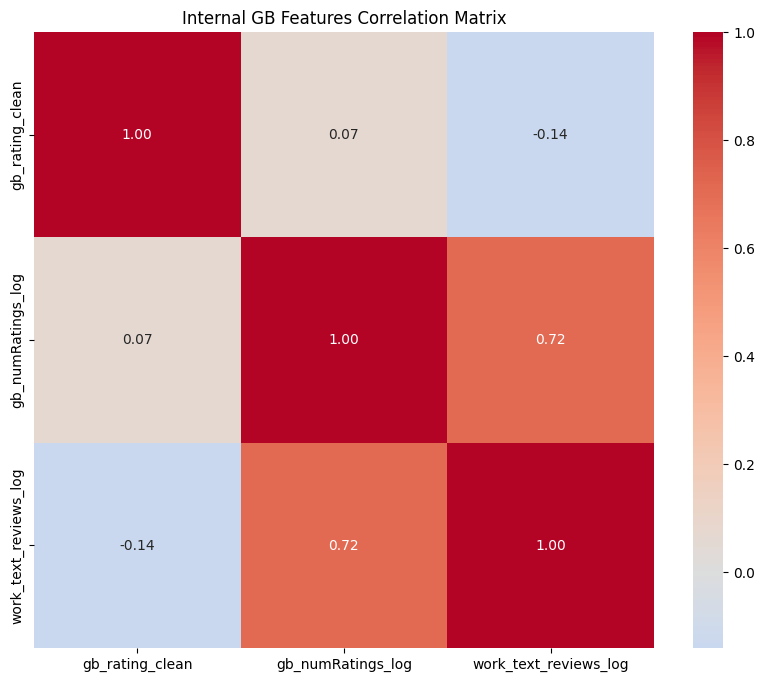

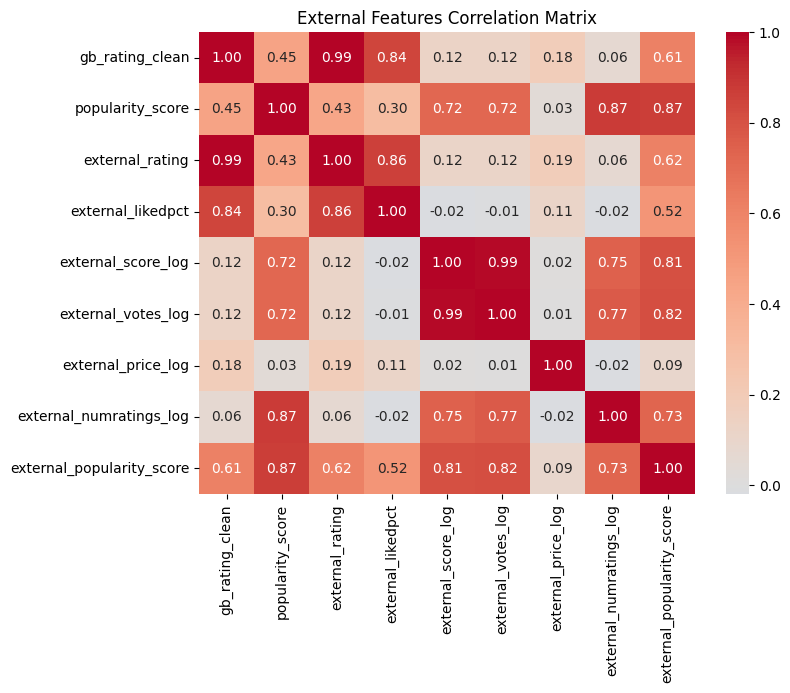

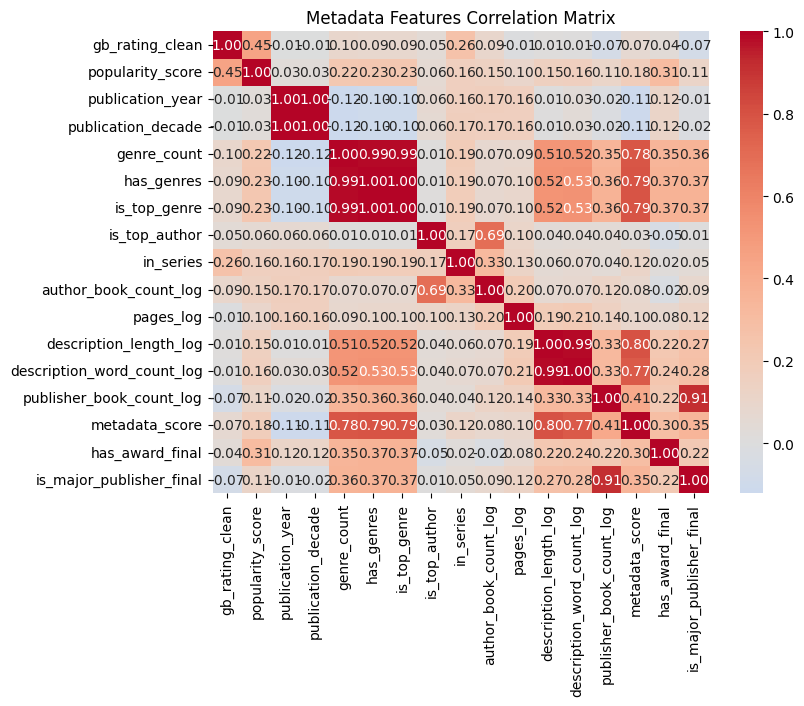

Internal Satisfaction Signal correlations with gb_rating_clean:


,correlation
gb_rating_clean,1.000000
gb_numRatings_log,0.066222
work_text_reviews_log,-0.140205


External Signal correlations with gb_rating_clean:


,correlation
gb_rating_clean,1.000000
external_rating,0.993573
external_likedpct,0.843361
external_popularity_score,0.614233
popularity_score,0.447247
external_price_log,0.183489
external_score_log,0.123981
external_votes_log,0.120865
external_numratings_log,0.064638


External Signal correlations with popularity_score:


,correlation
popularity_score,1.000000
external_numratings_log,0.874212
external_popularity_score,0.872410
external_votes_log,0.724376
external_score_log,0.718134
gb_rating_clean,0.447247
external_rating,0.430675
external_likedpct,0.301216
external_price_log,0.033899


Metadata Feature correlations with gb_rating_clean:


,correlation
gb_rating_clean,1.000000
popularity_score,0.447247
in_series,0.259574
genre_count,0.095082
author_book_count_log,0.088608
has_genres,0.087584
is_top_genre,0.087584
metadata_score,0.067245
is_top_author,0.046215
has_award_final,0.038392


Metadata Feature correlations with popularity_score:


,correlation
popularity_score,1.000000
gb_rating_clean,0.447247
has_award_final,0.309243
has_genres,0.230417
is_top_genre,0.230417
genre_count,0.220376
metadata_score,0.178768
description_word_count_log,0.164480
in_series,0.162716
description_length_log,0.150212


In [37]:
# Convert boolean columns to float for correlation analysis
for col in ['has_award_final', 'is_major_publisher_final']:
    if col in merged_features.columns:
        merged_features[col] = merged_features[col].astype(float)

# split into internal and external categories
metadata_cols = [ 'gb_rating_clean', 'popularity_score', # target
    'publication_year', 'publication_decade', 'genre_count', 'has_genres', 'is_top_genre',
    'is_top_author', 'in_series', 'author_book_count_log', 'pages_log',
    'description_length_log', 'description_word_count_log', 'publisher_book_count_log',
    'metadata_score', 'has_award_final', 'is_major_publisher_final'
]

internal_satisfaction_cols = ['gb_rating_clean', # target
 'gb_numRatings_log', 'work_text_reviews_log'
]
external_cols = ['gb_rating_clean', 'popularity_score', # target
    'external_rating', 'external_likedpct', 'external_score_log', 'external_votes_log',
    'external_price_log', 'external_numratings_log', 'external_popularity_score',
]

# filter numeric columns
metadata_numeric = merged_features[metadata_cols].select_dtypes(include='number')
internal_numeric = merged_features[internal_satisfaction_cols].select_dtypes(include='number')
external_numeric = merged_features[external_cols].select_dtypes(include='number')

# internal correlation matrix
plt.figure(figsize=(10, 8))
internal_corr = internal_numeric.corr()
sns.heatmap(internal_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Internal GB Features Correlation Matrix")
plt.show()

# external correlation matrix
plt.figure(figsize=(8, 6))
external_corr = external_numeric.corr()
sns.heatmap(external_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("External Features Correlation Matrix")
plt.show()

# external correlation matrix
plt.figure(figsize=(8, 6))
metadata_corr = metadata_numeric.corr()
sns.heatmap(metadata_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Metadata Features Correlation Matrix")
plt.show()

# table: correlations with gb_rating_clean (internal satisfaction signals)
if 'gb_rating_clean' in internal_corr.columns:
    gb_rating_corr = internal_corr['gb_rating_clean'].sort_values(ascending=False)
    print("Internal Satisfaction Signal correlations with gb_rating_clean:")
    display(gb_rating_corr.to_frame('correlation'))

# table: correlations with popularity_score (internal satisfaction signals)
if 'popularity_score' in internal_corr.columns:
    popularity_corr = internal_corr['popularity_score'].sort_values(ascending=False)
    print("Internal Satisfaction Signal correlations with popularity_score:")
    display(popularity_corr.to_frame('correlation'))

# table: correlations with gb_rating_clean (external signals)
if 'gb_rating_clean' in external_corr.columns:
    ext_rating_corr = external_corr['gb_rating_clean'].sort_values(ascending=False)
    print("External Signal correlations with gb_rating_clean:")
    display(ext_rating_corr.to_frame('correlation'))

# table: correlations with popularity_score (external signals)
if 'popularity_score' in external_corr.columns:
    ext_pop_corr = external_corr['popularity_score'].sort_values(ascending=False)
    print("External Signal correlations with popularity_score:")
    display(ext_pop_corr.to_frame('correlation'))
    
# table: correlations with gb_rating_clean (metadata)
if 'gb_rating_clean' in metadata_corr.columns:
    metadata_rating_corr = metadata_corr['gb_rating_clean'].sort_values(ascending=False)
    print("Metadata Feature correlations with gb_rating_clean:")
    display(metadata_rating_corr.to_frame('correlation'))

# table: correlations with popularity_score (metadata)
if 'popularity_score' in metadata_corr.columns:
    metadata_pop_corr = metadata_corr['popularity_score'].sort_values(ascending=False)
    print("Metadata Feature correlations with popularity_score:")
    display(metadata_pop_corr.to_frame('correlation'))

Based on the correlation analysis, using `popularity_score` as the target variable is strongly justified. Unlike `gb_rating_clean`, which shows weak correlations with most metadata and external features, `popularity_score` demonstrates consistently higher and more meaningful correlations across a broad range of predictors, including both internal and external signals. This indicates that `popularity_score` better captures the multifaceted nature of book success, reflecting not only average ratings but also engagement and visibility. As a composite metric, it is less susceptible to sample-size bias and rating inflation, making it a more robust and informative target for predictive modeling. We will confirm this by applying PPS analysis as well.

In [48]:
# Save correlation matrices as CSV in outputs/eda_plots
internal_corr.to_csv("outputs/eda_plots/internal_corr_matrix.csv")
external_corr.to_csv("outputs/eda_plots/external_corr_matrix.csv")
metadata_corr.to_csv("outputs/eda_plots/metadata_corr_matrix.csv")

# Upload correlation matrices to HuggingFace Hub under corr_matrix folder
corr_files = [
    "internal_corr_matrix.csv",
    "external_corr_matrix.csv",
    "metadata_corr_matrix.csv"
]

from huggingface_hub import HfApi
from pathlib import Path
import os

api = HfApi()
repo_id = "revolucia/bookwise-analytics-ml"
repo_type = "dataset"
HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
plots_dir = Path("outputs/eda_plots")
plots_dir.mkdir(parents=True, exist_ok=True)

for fname in corr_files:
    fpath = plots_dir / fname
    if fpath.exists() and HF_TOKEN:
        print(f"Uploading: {fname}...\n")
        api.upload_file(
            path_or_fileobj=str(fpath),
            path_in_repo=f"corr_matrix/{fname}",  # Upload to corr_matrix folder
            repo_id=repo_id,
            repo_type=repo_type,
            token=HF_TOKEN
        )
        print(f"Uploaded: {fname}\n")
print("Correlation matrix CSV upload process completed.")

Uploading: internal_corr_matrix.csv...

Uploaded: internal_corr_matrix.csv

Uploading: external_corr_matrix.csv...

Uploaded: external_corr_matrix.csv

Uploading: metadata_corr_matrix.csv...

Uploaded: metadata_corr_matrix.csv

Correlation matrix CSV upload process completed.


# PPS Analysis

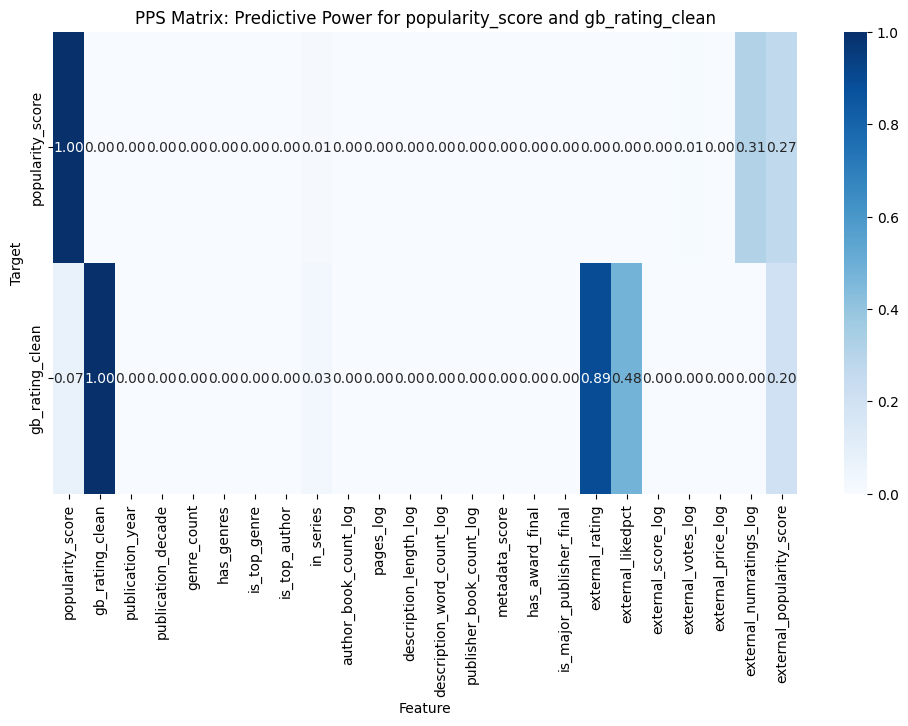

In [ ]:
import ppscore as pps
import pandas as pd

# Compute PPS matrix for selected features
pps_features = [
    'popularity_score', 'gb_rating_clean', 'publication_year', 'publication_decade', 'genre_count',
    'has_genres', 'is_top_genre', 'is_top_author', 'in_series', 'author_book_count_log', 'pages_log',
    'description_length_log', 'description_word_count_log', 'publisher_book_count_log',
    'metadata_score', 'has_award_final', 'is_major_publisher_final',
    'external_rating', 'external_likedpct', 'external_score_log', 'external_votes_log',
    'external_price_log', 'external_numratings_log', 'external_popularity_score'
]

pps_matrix = pd.DataFrame([
    [pps.score(merged_features, x, y)['ppscore'] for y in pps_features]
    for x in pps_features
], columns=pps_features, index=pps_features)

#  PPS for popularity_score and gb_rating_clean
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(pps_matrix.loc[['popularity_score', 'gb_rating_clean']], annot=True, cmap='Blues', fmt=".2f")
plt.title("PPS Matrix: Predictive Power for popularity_score and gb_rating_clean")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

Although the PPS scores for `popularity_score` are lower than those for `gb_rating_clean`, selecting `popularity_score` as the target is justified because the business goal is to model engagement, not just perceived quality. 

Correlation analysis shows that `popularity_score` is more broadly associated with a diverse set of metadata and external features, reflecting both visibility and user interaction. As a composite metric, it captures multiple facets of book success and is less biased by sample size or rating inflation, making it a more robust and relevant target for predicting engagement outcomes.

# Clean up and Save Datasets

In [44]:
drop_cols = [
    'gb_rating_clean',  # popularity_score components
    'gb_numRatings_log',  # popularity_score components
    'work_text_reviews_log',  # popularity_score components
    'title_final',  # no/low predictive value
    'author_final', # -> could be hot-encoded later if needed
    'authors_list_final', # is_top_author is retained
    'series_final',  # in_series is retained
    'publisher_final', # is_major_publisher_final is retained
    'genres_final',  # has_genres and is_top_genre are retained
    'genres_simple_final', #->  could be hot-encoded later if needed
    'description_final',  # description_length_log and description_word_count_log are retained
    'description_nlp_final',
    'external_bookformat' # could be hot-encoded later if needed
]

merged_features = merged_features.drop(columns=[col for col in drop_cols if col in merged_features.columns])

# Save the cleaned dataset for modeling
from pathlib import Path
v = '1'  # versioning placeholder
modeling_dir = Path(f'outputs/datasets/modeling/{v}')
modeling_dir.mkdir(parents=True, exist_ok=True)
merged_features.to_csv(modeling_dir / 'final_features.csv', index=False)
user_profile.to_csv(modeling_dir / 'user_profile_features.csv', index=False)